Optimal transport
=================

Sdot specializes in semi-discrete optimal transport, meaning that exactly one of the two measures must be a sum of diracs.

The only transport cost currently managed is based on the Euclidean norm (research is underway for tools based on other norms... but this is still a long way from production).

Sdot provides tools for manipulating transport plans, and in particular for finding optimal ones.

Under the hood, it's largely based on the power diagram tools, for which major optimization efforts have been made (execution speed, memory handling, ...).

A basic example
---------------

In [1]:
!pip install sdot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.8/99.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 37.8 MB/s eta 0:00:00
  Created wheel for pysdot: filename=pysdot-0.2.24-cp310-cp310-linux_x86_64.whl size=16016455 sha256=0bdab966fd721972be5ed1ee5c68ec2b238817c8ae8bf6c466dd4078e8550192
  Stored in directory: /root/.cache/pip/wheels/a8/d2/9c/63b22bd73693bda2f87525f18efc6c5fd33b11ca74d9f2522a
Successfully built pysdot


max_error_ratio: 2.0225e+00 (first iteration) 
max_error_ratio: 4.8932e-01 nb_relaxation_steps: 0 
max_error_ratio: 2.4630e-02 nb_relaxation_steps: 0 
max_error_ratio: 1.0051e-04 nb_relaxation_steps: 0 
max_error_ratio: 2.4810e-09 nb_relaxation_steps: 0 


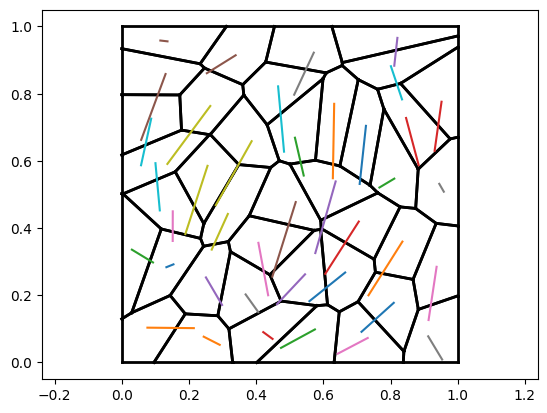

In [2]:
from sdot import optimal_transport_plan
import numpy as np

# find an optimal plan to go from diracs to an UnitBox
tp = optimal_transport_plan(
    np.random.random( [ 40, 2 ] ), # an array is considered as a set of dirac positions
)

# tp is of type SdotPlan
tp.plot()


In the following example, we use more explicit types (to do roughly the same thing). As we will see, it is possible to have the diracs either in the source or either in the target density.

max_error_ratio: 2.0537e+00 (first iteration) 
max_error_ratio: 1.0689e+00 nb_relaxation_steps: 0 
max_error_ratio: 9.7119e-01 nb_relaxation_steps: 1 
max_error_ratio: 1.0691e-01 nb_relaxation_steps: 0 
max_error_ratio: 2.5223e-03 nb_relaxation_steps: 0 
max_error_ratio: 1.4469e-06 nb_relaxation_steps: 0 


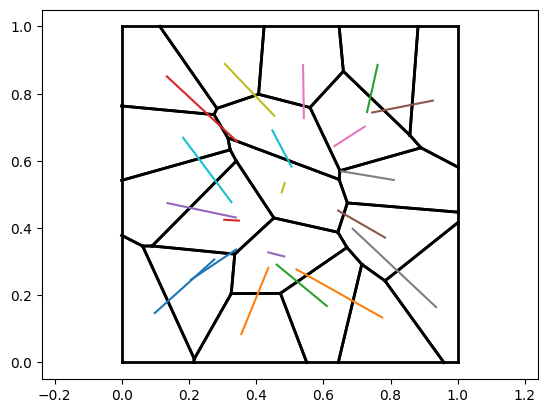

In [3]:
from sdot import SumOfDiracs, UnitBox

# we use another dirac positions for illustration
positions = np.random.random( [ 20, 2 ] ) * 0.5 + 0.25

# find an optimal plan to go from diracs to an UnitBox
tp = optimal_transport_plan(
    source_measure = SumOfDiracs( positions ),
    target_measure = UnitBox(),
    stop_when = { 'max_error_ratio': 1e-4 }, # stopping criterion (actually the default value)
    display = [ 'max_error_ratio' ] # what to display during execution (actually also the default value)
)

# tp is of type SdotPlan
tp.plot()

`optimal_transport_plan` returns a `SdotPlan` instance which contains methods to analyse the transport plans

Direct use of SdotPlan
-----------------------------

Functions like `optimal_transport_plan`, `optimal_partial_transport_plan` and `optimal_moreau_yosida_transport_plan` are actually very thin wrapper around the `SdotPlan` class. They simply call the constructor and the method `adjust_potentials` before returning the created instance.

If you plan to work on several successive transport plans that share similar datasets, it can be very profitable to directly use instances of `SdotPlan`. It provides the same level of usability, while allowing a wide number of optimizations in terms of execution speed and memory usage (for instance, it may avoid to recompute the acceleration structures, ...).


max_error_ratio: 1.0494e+01 (first iteration) 
max_error_ratio: 5.7076e+00 nb_relaxation_steps: 1 max_dw: 4.0009e-01 
max_error_ratio: 9.8443e-01 nb_relaxation_steps: 0 max_dw: 1.4277e-01 
max_error_ratio: 1.1886e-01 nb_relaxation_steps: 0 max_dw: 1.4645e-02 
max_error_ratio: 2.9830e-03 nb_relaxation_steps: 0 max_dw: 1.2698e-03 
max_error_ratio: 1.9284e-06 nb_relaxation_steps: 0 max_dw: 2.3086e-05 
max_error_ratio: 1.7007e-01 nb_relaxation_steps: 0 max_dw: 2.3086e-05 
max_error_ratio: 1.1629e-02 nb_relaxation_steps: 0 max_dw: 9.1889e-03 
max_error_ratio: 3.3149e-05 nb_relaxation_steps: 0 max_dw: 2.0115e-04 


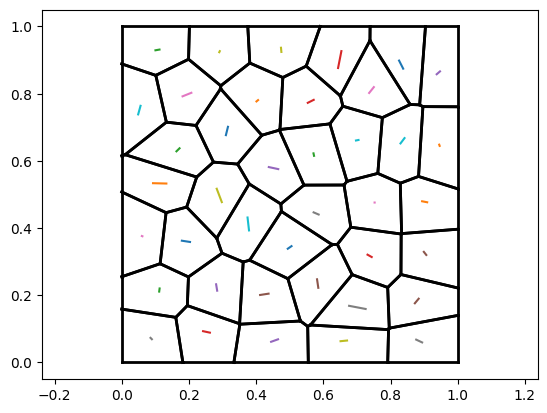

In [4]:
from sdot import SdotPlan
import numpy as np

tp = SdotPlan( np.random.random( [ 40, 2 ] ) * 0.5 )

# ctor argument can be defined or redefined after calling the constructor
tp.target_measure = UnitBox()

# one can default parameters, for instance for the solver
tp.display.max_dw = True

# call the solves (uses a Newton solver by default)
tp.adjust_potentials()

# it's possible to change only some parts of the inputs without having to redefine and recompute everything
tp.dirac_positions = tp.power_diagram.cell_barycenters()

# Make the Transport Plan valid and Optimal Again
tp.adjust_potentials()

# it was the first iteration of a quantization procedure
tp.plot()


# Analysis of the plan

Attributes like `sdot_plan.power_diagram` may be convenient for some kinds of tasks, but it's actually more internal cooking than something really related to optimal transport...

For more mathematically comprehensive analysis, you have the `sdot_plan.forward_map` (from the source measure to the target one) and the `sdot_plan.backward_map` (from the target measure to the source one) which contains the following getter attributes:
* kantorovitch_potentials
* brenier_potentials
* dirac_indices
* barycenters

When the maps go from diracs (source) to generic densities (target), these method actually give vectors with a value for each dirac:
* kantorovitch_potentials = $\psi_i$ (weights in the power diagram)
* brenier_potentials = discrete Brenier potentials for each dirac (convex if `tp` is optimal) $\psi_i + y_i^2$
* dirac_indices = identity vector (not very exciting)
* barycenters = barycenter for each cell

When the maps go from generic densities (source) to diracs (target), the methods are functions of $x$. To give mode details in this case:
* kantorovitch_potentials = $\phi( x ) = \psi_i + ( x - y_i ) ^ 2$
* brenier_potentials = $\phi( x ) - x^2$
* dirac_indices = $x$ to dirac index (also equal to the seed index) for the cell containing $x$
* barycenters = position of the dirac for the cell containing $x$

By convention the duality is under the form $\psi(y)-\phi_i \leq |y-X_i|^2$. otherwise $x\in Lag_i$ if $|y-X_i|^2-\phi_i\leq |y-X_j|^2-\phi_j$ for all $j$


In [ ]:
tp = optimal_transport_plan( np.random.random( [ 40, 2 ] ) * 0.5 )
# tp.backward_map.brenier_potential.plot() => should show a nice convex function

## Common generic densities

We have already seen the ubiquitous `UnitBox` class (which can actually be moved in the space, "Unit" refering to the target mass). Currently, one can also (will be able to ?) use
* `Mesh`: an interpolated simplex mesh
* `ScaledImage`: an interpolated image with possible affine transformations (more efficient than `Mesh` if possible to use)
* `SymbolicFunction`: generic representation of a density (stored internally as a graph of mathematical operations, as for instance in SymPy).

Ultimately, every densities all the densities end up as a symbolic expression, that is canonicalized, analysed to generate and call the correct code. To be complete, symbolic expression may of course contain meshes, images, and so on.

It provides a way to specify uncommon functions (e.g. `"exp(-w*(x-y)^2)"`, `"w"` being the Kantorovitch potential, `"y"` the dirac position). It is also possible to combine several densities. For instance, `UnitBox() - UnitBox( TransformationMatrix( translation = [ 0.25, 0.25 ], scaling = 0.5 ) )` gives a way to define a square with a hole.
